In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Optimizer

from tensorflow.keras.metrics import Mean, CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

## Ensuring Reproducibility of the Code

In [ ]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Use GPU deterministic computation (if available)
tf.config.experimental.enable_tensor_float_32_execution(True)

# Configure TensorFlow for reproducibility
tf.config.run_functions_eagerly(True)  # Execute operations eagerly for determinism
tf.config.threading.set_inter_op_parallelism_threads(1)  # Control parallelism for determinism

## Loading CIFAR-10 Data




In [ ]:
# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (val_images, val_labels) = cifar10.load_data()
train_images, val_images = train_images / 255.0, val_images / 255.0
train_labels, val_labels = to_categorical(train_labels), to_categorical(val_labels)

In [ ]:
# Convert NumPy arrays to TensorFlow datasets
minibatch_size = 512  # 512 in the paper

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(minibatch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(minibatch_size)

2024-02-11 18:37:24.388327: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-11 18:37:24.388358: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-11 18:37:24.388362: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-11 18:37:24.388395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-11 18:37:24.388407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Defining VGG model architecture

In [ ]:
class VGGModel:
    def __init__(self, input_shape=(32, 32, 3), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential()

        # Block 1
        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=self.input_shape))
        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Block 2
        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Block 3
        model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Block 4
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Block 5
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Flatten
        model.add(layers.Flatten())

        # Dense layers
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        return model

    def compile_model(self, optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def summary(self):
        self.model.summary()

## VGG16 Model with SGD

### Creating and Training the Model

In [ ]:
# Create an instance of the VGGModel class with SGD optimizer
model_sgd = VGGModel(input_shape=(32, 32, 3), num_classes=10)
model_sgd.compile_model(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_sgd.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                   

In the SGD-SA paper, they use Scheduled-SGD implementation of SGD. It is quite basic but still rather eﬀective on CIFAR-10 dataset: it uses no momentum/Nesterov acceleration, and the learning rate is set according the following schedule: η =0.1 for ﬁrst 30 epochs, 0.01 for the next 40 epochs, and 0.001 for the ﬁnal 30 epochs.

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(epoch):
    # if epoch < 30:
    #     return 0.1
    if epoch < 70:
        return 0.01
    else:
        return 0.001

# Create the LearningRateScheduler callback
learning_rate_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Training
epochs = 100  # Total number of epochs

history_sgd = model_sgd.model.fit(train_dataset,
                                  epochs=epochs,
                                  validation_data=val_dataset,
                                  callbacks=[learning_rate_scheduler])

Epoch 1/100
98/98 [==============================] - 53s 541ms/step - loss: 2.3026 - accuracy: 0.1019 - val_loss: 2.3025 - val_accuracy: 0.1726 - lr: 0.0100
Epoch 2/100
98/98 [==============================] - 33s 336ms/step - loss: 2.3025 - accuracy: 0.1165 - val_loss: 2.3025 - val_accuracy: 0.1554 - lr: 0.0100
Epoch 3/100
98/98 [==============================] - 33s 336ms/step - loss: 2.3025 - accuracy: 0.1162 - val_loss: 2.3025 - val_accuracy: 0.1523 - lr: 0.0100
Epoch 4/100
98/98 [==============================] - 34s 345ms/step - loss: 2.3025 - accuracy: 0.1193 - val_loss: 2.3024 - val_accuracy: 0.1510 - lr: 0.0100
Epoch 5/100
98/98 [==============================] - 33s 336ms/step - loss: 2.3024 - accuracy: 0.1233 - val_loss: 2.3024 - val_accuracy: 0.1541 - lr: 0.0100
Epoch 6/100
98/98 [==============================] - 33s 337ms/step - loss: 2.3024 - accuracy: 0.1272 - val_loss: 2.3024 - val_accuracy: 0.1576 - lr: 0.0100
Epoch 7/100
98/98 [==============================] - 33s 3

Epoch 53/100
98/98 [==============================] - 33s 336ms/step - loss: 2.0072 - accuracy: 0.2589 - val_loss: 1.9810 - val_accuracy: 0.2685 - lr: 0.0100
Epoch 54/100
98/98 [==============================] - 33s 336ms/step - loss: 1.9961 - accuracy: 0.2630 - val_loss: 1.9720 - val_accuracy: 0.2664 - lr: 0.0100
Epoch 55/100
98/98 [==============================] - 33s 336ms/step - loss: 1.9865 - accuracy: 0.2669 - val_loss: 1.9590 - val_accuracy: 0.2722 - lr: 0.0100
Epoch 56/100
98/98 [==============================] - 33s 336ms/step - loss: 1.9746 - accuracy: 0.2720 - val_loss: 1.9447 - val_accuracy: 0.2796 - lr: 0.0100
Epoch 57/100
98/98 [==============================] - 33s 336ms/step - loss: 1.9643 - accuracy: 0.2751 - val_loss: 1.9318 - val_accuracy: 0.2836 - lr: 0.0100
Epoch 58/100
98/98 [==============================] - 33s 336ms/step - loss: 1.9555 - accuracy: 0.2777 - val_loss: 1.9215 - val_accuracy: 0.2918 - lr: 0.0100
Epoch 59/100
98/98 [==============================] 

In [ ]:
# Taking a look at the training history
history_sgd.history

{'loss': [2.302560806274414,
  2.3025174140930176,
  2.302492618560791,
  2.30246901512146,
  2.302445411682129,
  2.302424907684326,
  2.302403211593628,
  2.3023810386657715,
  2.3023581504821777,
  2.302333354949951,
  2.3023080825805664,
  2.302278995513916,
  2.3022477626800537,
  2.302213668823242,
  2.302178382873535,
  2.302138328552246,
  2.302093744277954,
  2.302044630050659,
  2.301987886428833,
  2.3019235134124756,
  2.3018479347229004,
  2.30176043510437,
  2.301659107208252,
  2.301541328430176,
  2.3013975620269775,
  2.301225423812866,
  2.3010189533233643,
  2.300760269165039,
  2.300448179244995,
  2.3000600337982178,
  2.299567937850952,
  2.2989306449890137,
  2.2981069087982178,
  2.2970149517059326,
  2.2955336570739746,
  2.293470621109009,
  2.290496826171875,
  2.2860004901885986,
  2.2787137031555176,
  2.265469789505005,
  2.23567795753479,
  2.181682586669922,
  2.1548733711242676,
  2.1357250213623047,
  2.115049362182617,
  2.0994722843170166,
  2.079865

In [ ]:
# Final Validation Loss and Validation Accuracy after the training is complete

# val_loss, val_acc = model_sgd.model.evaluate(val_images, val_labels)
# print('Validation Loss:', val_loss)
# print('Validation Accuracy:', val_acc)

### Saving the Model and Training History

In [ ]:
# Save the model in native Keras format
model_sgd.model.save('output/models/model_scheduled_sgd_512B.keras')

# To load the saved model later:
# loaded_model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Save the training history
with open('output/models/history_sgd_512B.pkl', 'wb') as file:
    pickle.dump(history_sgd.history, file)

## VGG16 Model with SGD-SA


In [ ]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### Creating and Training the Model

In [ ]:
# Create the VGG model that will be trained with SGD-SA
model_sgd_sa = VGGModel(input_shape=(32, 32, 3), num_classes=10)

# Define the loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Convert NumPy arrays to TensorFlow datasets
minibatch_size = 16  # 512 in the paper
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(minibatch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(minibatch_size)

epochs = 100

# Chosen values for Learning Rates
lr_options =  [0.1, 0.07, 0.05, 0.03, 0.01, 0.007, 0.005, 0.003, 0.001, 0.0007, 0.0005, 0.0003, 0.0001]  # Defaults to 0.01 in SGD
#lr_options =  [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05]  # in existing SGD-SA paper

temperature = 1
cooling = 0.8 # in The paper: 0.8

In [ ]:
def accept_update(old_loss, new_loss, temperature):
        # Metropolis acceptance criteria
        worsening = new_loss - old_loss
        probability = np.exp((-worsening) / temperature)
        random_number = random.random()
        # if random_number < probability:
        #   #print(random_number, probability, "True")
        #   return True,
        # else:
        #   #print(random_number, probability, "False")
        #   return False
        return random_number < probability, worsening > 0

**Important remark before training:**

For tracking loss values during training, we will use `tf.keras.metrics.Mean()`. This metric calculates the mean of the values observed across all batches.

`tf.keras.metrics.CategoricalCrossentropy()` is not suitable for tracking loss values during training. Instead, it's used as a loss function to compute the categorical cross-entropy loss between the true labels and the predicted probabilities.

In summary:
* Use `tf.keras.metrics.Mean()` to track the loss values during training.
* Use `tf.keras.losses.CategoricalCrossentropy()` as the loss function during training.

In [ ]:
###########################################
### Customized Training Loop for SGD-SA ###
###########################################

# Initialize metrics objects for both training and validation
train_loss_metric = tf.keras.metrics.Mean()
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
val_loss_metric = tf.keras.metrics.Mean()
val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()


# Initialize empty lists to store loss and accuracy values (to construct "history")
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
temperature_history = []
rejected_history = []
accepted_worse_history = []


##### MAIN TRAINING LOOP #####

for epoch in range(epochs):

    # Reset metrics for the new epoch
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()
    val_loss_metric.reset_states()
    val_accuracy_metric.reset_states()

    # Reset epoch-level counts
    accepted = 0
    rejected = 0
    accepted_worse = 0

    ##### TRAINING #####
    for batch, (x_batch, y_batch) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model_sgd_sa.model(x_batch)
            # Compute the loss
            loss = loss_fn(y_batch, predictions)

        # Save the current weights and loss as "old"
        old_weights = model_sgd_sa.model.trainable_variables
        old_loss = loss.numpy()
        #print("old_loss", old_loss)

        # Compute Gradients
        gradients = tape.gradient(loss, model_sgd_sa.model.trainable_variables)

        random_lr = np.random.choice(lr_options)  # Select a random Learning Rate

        # Update weights using gradient descent
        for var, grad in zip(model_sgd_sa.model.trainable_variables, gradients):
            var.assign_sub(random_lr * grad)

        # Compute the new Loss (after weights update)
        predictions_after_update = model_sgd_sa.model(x_batch)
        new_loss = loss_fn(y_batch, predictions_after_update)
        #print("New Loss after Weight Update:", new_loss.numpy())


        # Check acceptance criteria
        #if not accept_update(old_loss, new_loss, temperature):
        is_accepted, worsening = accept_update(old_loss, new_loss, temperature)
        if not is_accepted:
            # Reverting update
            model_sgd_sa.model.set_weights(old_weights)
            # Update Criterion Rejection Count
            rejected += 1
            # Update Epoch Metrics
            train_loss_metric.update_state(old_loss)
            train_accuracy_metric.update_state(y_batch, predictions)
        else:
            # Update Criterion Acceptance Count
            accepted += 1
            # Update Epoch Metrics
            train_loss_metric.update_state(new_loss)
            train_accuracy_metric.update_state(y_batch, predictions_after_update)
            if worsening:
                accepted_worse +=1
                # print(f"Epoch: {epoch + 1}, Batch: {batch}, Previous Loss: {loss.numpy()}, New Loss: {new_loss.numpy()}, LR: {random_lr}, Temperature: {temperature}, A/R: {accepted}/{rejected}")

        # # Print progress
        # if batch % 500 == 0:
        #     print(f"Epoch: {epoch + 1}, Batch: {batch}, Previous Loss: {loss.numpy()}, New Loss: {new_loss.numpy()}, LR: {random_lr}, Temperature: {temperature}, A/R: {accepted}/{rejected}")


    ##### VALIDATION #####
    for batch, (x_val_batch, y_val_batch) in enumerate(val_dataset):
        # Forward pass
        val_predictions = model_sgd_sa.model(x_val_batch)
        # Compute the validation loss
        val_loss = loss_fn(y_val_batch, val_predictions)
        # Update validation metrics
        val_loss_metric.update_state(val_loss)
        val_accuracy_metric.update_state(y_val_batch, val_predictions)

    ##### EPOCH RESULTS #####

    # Update Temperature
    temperature = cooling * temperature


    # Store the epoch-level training and validation loss and accuracy into history lists
    train_loss_history.append(train_loss_metric.result().numpy())
    train_accuracy_history.append(train_accuracy_metric.result().numpy())
    val_loss_history.append(val_loss_metric.result().numpy())
    val_accuracy_history.append(val_accuracy_metric.result().numpy())

    # Store temperature and the corresponding rejection count for the epoch
    temperature_history.append(temperature)
    rejected_history.append(rejected)
    accepted_worse_history.append(accepted_worse)


    # Print train and validation loss and accuracy for the epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"loss: {train_loss_metric.result():.4f} - accuracy: {train_accuracy_metric.result():.4f} - val_loss: {val_loss_metric.result():.4f} - val_accuracy: {val_accuracy_metric.result():.4f} - rejected: {rejected}/{accepted+rejected} - accepted_worse: {accepted_worse}")


# Construct the history object
history_sgd_sa = {
    'loss': train_loss_history,
    'accuracy': train_accuracy_history,
    'val_loss': val_loss_history,
    'val_accuracy': val_accuracy_history,
    'temperature': temperature_history,
    'rejected': rejected_history,
    'accepted_worse': accepted_worse_history
}

Epoch 1/100
loss: 2.3022 - accuracy: 0.1051 - val_loss: 2.3028 - val_accuracy: 0.1000 - rejected: 0/3125 - accepted_worse: 0
Epoch 2/100
loss: 2.3023 - accuracy: 0.1034 - val_loss: 2.3036 - val_accuracy: 0.1000 - rejected: 0/3125 - accepted_worse: 0
Epoch 3/100
loss: 2.3022 - accuracy: 0.1052 - val_loss: 2.3037 - val_accuracy: 0.1000 - rejected: 0/3125 - accepted_worse: 0
Epoch 4/100
loss: 2.3026 - accuracy: 0.1028 - val_loss: 2.3031 - val_accuracy: 0.1000 - rejected: 0/3125 - accepted_worse: 0
Epoch 5/100
loss: 2.3024 - accuracy: 0.1047 - val_loss: 2.3033 - val_accuracy: 0.1000 - rejected: 0/3125 - accepted_worse: 0
Epoch 6/100
loss: 2.3024 - accuracy: 0.1054 - val_loss: 2.3040 - val_accuracy: 0.1000 - rejected: 0/3125 - accepted_worse: 0
Epoch 7/100
loss: 2.3026 - accuracy: 0.1031 - val_loss: 2.3043 - val_accuracy: 0.1000 - rejected: 0/3125 - accepted_worse: 0
Epoch 8/100
loss: 2.3023 - accuracy: 0.1032 - val_loss: 2.3034 - val_accuracy: 0.1000 - rejected: 0/3125 - accepted_worse: 0


In [ ]:
### CHECKING RESULTS ON VALIDATION DATASET (after the Training is complete)

# Initialize the metrics
categorical_crossentropy = tf.keras.losses.CategoricalCrossentropy()
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

# Iterate through the test dataset
for x_test_batch, y_test_batch in val_dataset:
    # Make predictions using the trained model
    predictions = model_sgd_sa.model(x_test_batch)

    # Calculate Categorical Crossentropy
    loss_value = categorical_crossentropy(y_test_batch, predictions)

    # Update Categorical Accuracy
    categorical_accuracy.update_state(y_test_batch, predictions)

# Get the final results
average_loss = loss_value.numpy()
accuracy = categorical_accuracy.result().numpy()

print(f'Validation Loss: {average_loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Loss: 0.6296
Validation Accuracy: 0.7427


### Saving the Model and Training History

In [ ]:
# Save the model in native Keras format
model_sgd_sa.model.save('output/models/model_sgd_sa_512B.keras')

In [ ]:
# Save the training history
with open('output/models/history_sgd_sa_512B.pkl', 'wb') as file:
    pickle.dump(history_sgd_sa, file)

## Visualizing Training History for Both Algorithms

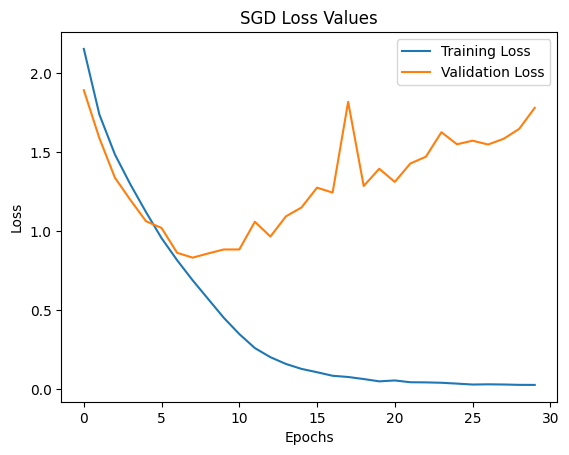

In [ ]:
# Plot the training history - Loss values
plt.plot(history_sgd.history['loss'], label='Training Loss')
plt.plot(history_sgd.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SGD Loss Values')
plt.legend()
plt.show()

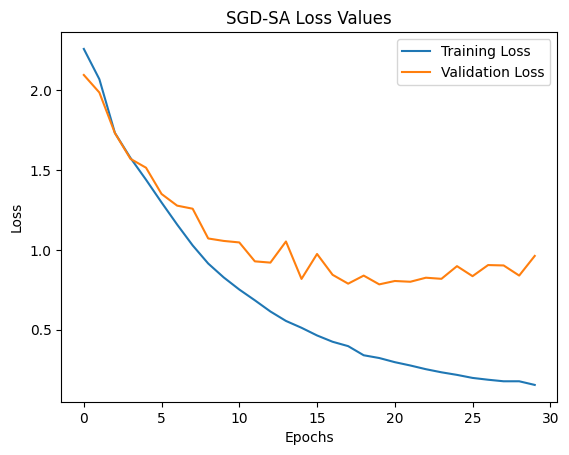

In [ ]:
# Plot the training history for SGD-SA (Loss values)
plt.plot(history_sgd_sa['loss'], label='Training Loss')
plt.plot(history_sgd_sa['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('SGD-SA Loss Values')
plt.show()

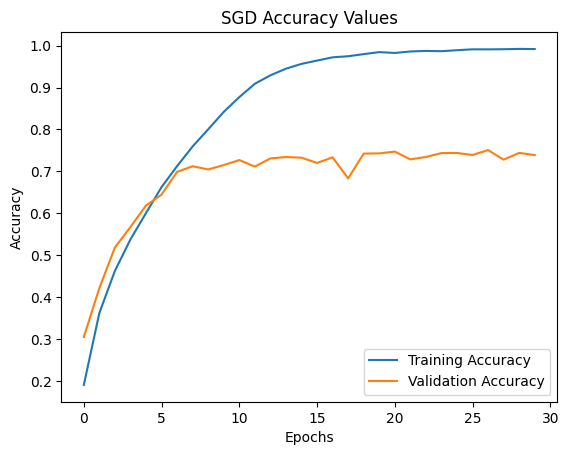

In [ ]:
# Plot the training history - Accuracy values
plt.plot(history_sgd.history['accuracy'], label='Training Accuracy')
plt.plot(history_sgd.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SGD Accuracy Values')
plt.show()

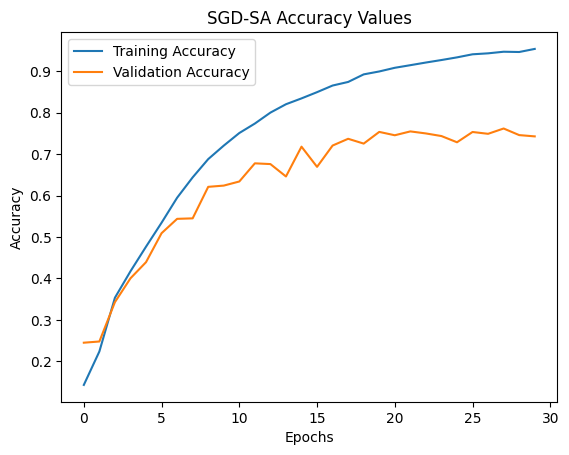

In [ ]:
# Plot the training history for SGD-SA (Accuracy values)
plt.plot(history_sgd_sa['accuracy'], label='Training Accuracy')
plt.plot(history_sgd_sa['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SGD-SA Accuracy Values')
plt.show()

In [ ]:
### TO DO:

# 0. Check Reproducibility! (seeds were not enough!)

# 1. Add not just rejection/acception but statistics for worse solution accepted

# 2. Fix Temperature values after cooling - remove insignificant digits

# 3. Re-train and Visualize results on graphs

# 4. Implement SGD schedule as in paper (so called Scheduled-SGD):
# η =0.1 for ﬁrst 30 epochs, 0.01 for the next 40 epochs, and 0.001 for the ﬁnal 30 epochs.

# 5. Try calculating 2 neigbours at a time and taking the best one (analyse results afterwards)

# 6. Try generating LR randomly from interval (rather than picking randomly from the defined set of values)

# 7. Modification of previous step: Try generating LR as normally distributed around default 0.01

# 8. Make print outs prittier - probably add timer for the epoch execution